<a href="https://colab.research.google.com/github/astrodeepnet/sbi_experiments/blob/ramp_bijector/notebooks/score_matching/NF_implicit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nomalizing Flow with implicit coupling layers


In [1]:
!pip install --quiet --upgrade dm-haiku optax tensorflow-probability
!pip install --quiet git+https://github.com/astrodeepnet/sbi_experiments.git@ramp_bijector

     |████████████████████████████████| 287 kB 6.8 MB/s 
     |████████████████████████████████| 126 kB 66.6 MB/s 
     |████████████████████████████████| 65 kB 4.8 MB/s 


In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2
import jax
import jax.numpy as jnp
import numpy as onp
import haiku as hk
import optax
from functools import partial
from tqdm import tqdm
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

Populating the interactive namespace from numpy and matplotlib


In [3]:
d=2
batch_size = 1024

In [4]:
from sbiexpt.distributions import get_two_moons
from sbiexpt.bijectors import ImplicitRampBijector

In [5]:
@jax.jit
def get_batch(seed):
  two_moons = get_two_moons(sigma= 0.05)
  batch = two_moons.sample(batch_size, seed=seed) / 5 + 0.45
  return batch

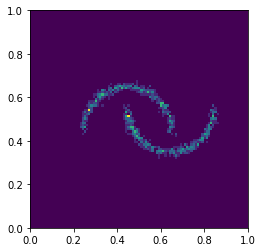

In [6]:
batch = get_batch(jax.random.PRNGKey(0))
hist2d(batch[:,0], batch[:,1],100, range=[[0,1],[0,1]]); gca().set_aspect('equal');

In [7]:
class CustomCoupling(hk.Module):
  """This is the coupling layer used in the Flow."""
  def __call__(self, x, output_units, **condition_kwargs):

    # NN to get a b and c
    net = hk.Linear(128)(x)
    net = jax.nn.leaky_relu(net)
    net = hk.Linear(128)(net)
    net = jax.nn.leaky_relu(net)
    
    log_a_bound=4
    min_density_lower_bound=1e-4
    
    log_a   = jax.nn.tanh(hk.Linear(output_units)(net)) * log_a_bound
    b   = jax.nn.sigmoid(hk.Linear(output_units)(net))
    c   = min_density_lower_bound + jax.nn.sigmoid(hk.Linear(output_units)(net)) * (1 - min_density_lower_bound)
    return ImplicitRampBijector(lambda x: x**5, jnp.exp(log_a),b,c)

class Flow(hk.Module):
    """A normalizing flow using the coupling layers defined
    above."""
    def __call__(self):
      chain = tfb.Chain([
            tfb.RealNVP(d//2, bijector_fn=CustomCoupling(name = 'b1')),
            tfb.Permute([1,0]),
            tfb.RealNVP(d//2, bijector_fn=CustomCoupling(name = 'b2')),
            tfb.Permute([1,0]),
            tfb.RealNVP(d//2, bijector_fn=CustomCoupling(name = 'b3')),
            tfb.Permute([1,0]),
            tfb.RealNVP(d//2, bijector_fn=CustomCoupling(name = 'b4')),
            tfb.Permute([1,0]),
        ])
      
      nvp = tfd.TransformedDistribution(
            tfd.Independent(tfd.TruncatedNormal(0.5*jnp.ones(d), 
                                                0.3*jnp.ones(d), 
                                                0.01,0.99),
                            reinterpreted_batch_ndims=1),
            bijector=chain)
        
      return nvp

In [8]:
model_NF = hk.without_apply_rng(hk.transform(lambda x : Flow()().log_prob(x)))
model_inv = hk.without_apply_rng(hk.transform(lambda x : Flow()().bijector.inverse(x)))
model_sample = hk.without_apply_rng(hk.transform(lambda : Flow()().sample(1024, seed=next(rng_seq))))

In [9]:
rng_seq = hk.PRNGSequence(12)
params = model_NF.init(next(rng_seq), jnp.zeros([1,d]))

In [10]:
# TO DO
@jax.jit
def loss_fn(params, batch):
  log_prob = model_NF.apply(params, batch)
  return -jnp.mean(log_prob)

In [11]:
@jax.jit
def update(params, opt_state, batch):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
  
    return loss, new_params, new_opt_state

In [42]:
learning_rate=0.0002
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

In [13]:
losses = []
master_seed = hk.PRNGSequence(0)

In [43]:
for step in tqdm(range(5000)):
    batch = get_batch(next(master_seed))
    l, params, opt_state = update(params, opt_state, batch)
    losses.append(l)

100%|██████████| 5000/5000 [01:24<00:00, 59.36it/s]


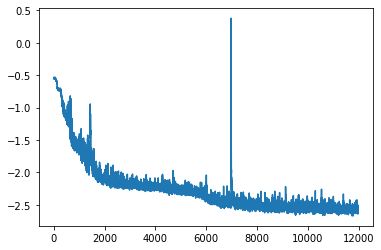

In [44]:
plot(losses[25:])

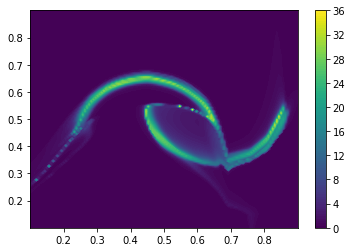

In [46]:
x = jnp.stack(jnp.meshgrid(jnp.linspace(0.1,0.9,128),
                           jnp.linspace(0.1,0.9,128)),-1)

im = model_NF.apply(params, x.reshape(-1,2)).reshape([128,128])
contourf(x[...,0],x[...,1],jnp.exp(im),100); colorbar()

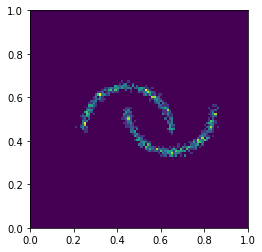

In [47]:
hist2d(batch[:,0], batch[:,1],100, range=[[0,1],[0,1]]);gca().set_aspect('equal');

In [48]:
x = model_inv.apply(params, batch)

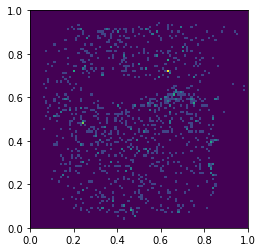

In [49]:
hist2d(x[:,0], x[:,1],100, range=[[0,1],[0,1]]);gca().set_aspect('equal');

In [50]:
x = model_sample.apply(params)

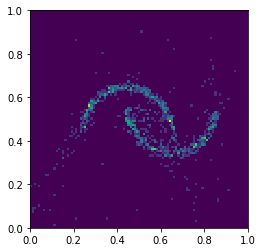

In [51]:
hist2d(x[:,0], x[:,1],100, range=[[0,1],[0,1]]);gca().set_aspect('equal');

In [22]:
coupl = hk.without_apply_rng(hk.transform(lambda x: CustomCoupling(name = 'b2')(x,1)))

In [23]:
predicate = lambda module_name, name, value: 'flow/b2' in module_name
params_b1 = hk.data_structures.filter(predicate, params) 

In [24]:
params_b1=hk.data_structures.to_mutable_dict(params_b1)
params_b1={k.split('flow/')[1]:params_b1[k] for k in params_b1.keys()}

In [25]:
t = jnp.linspace(0,1)
bij = coupl.apply(params_b1, t.reshape([50,1]))

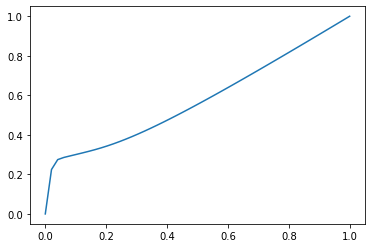

In [26]:
plot(t,bij(t)[30])

In [27]:
inv = bij.inverse(1*bij(t))

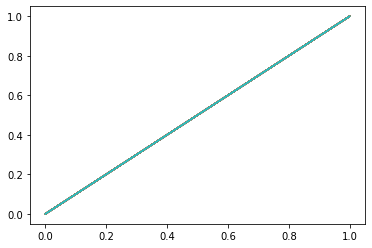

In [28]:
plot(t,inv.T)

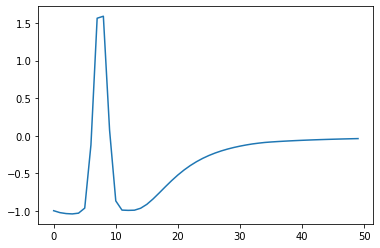

In [29]:
plot(bij.forward_log_det_jacobian(t.reshape([50,1])))

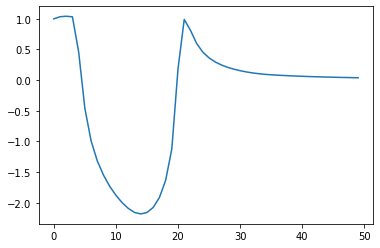

In [30]:
plot(bij.inverse_log_det_jacobian(t.reshape([50,1])))